In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn import metrics
import pandas_datareader.data as web
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split ,GridSearchCV , RandomizedSearchCV

# DATA PREPARATION

> ## 5.1 (a) Get Data

In [2]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

In [3]:
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [4]:
stk_data

Attributes   Adj Close                                Close              \
Symbols           MSFT         IBM        GOOGL        MSFT         IBM   
Date                                                                      
2017-02-24   60.321774  137.278839   847.809998   64.620003  173.374756   
2017-02-27   59.957726  135.802719   849.669983   64.230003  171.510513   
2017-02-28   59.724354  136.120636   844.929993   63.980000  171.912048   
2017-03-01   60.620510  137.733047   856.750000   64.940002  173.948380   
2017-03-02   59.752361  136.658096   849.849976   64.010002  172.590820   
...                ...         ...          ...         ...         ...   
2022-02-16  299.500000  129.179993  2754.760010  299.500000  129.179993   
2022-02-17  290.730011  124.970001  2650.780029  290.730011  124.970001   
2022-02-18  287.929993  124.349998  2608.060059  287.929993  124.349998   
2022-02-22  287.720001  123.919998  2596.270020  287.720001  123.919998   
2022-02-23  280.269989  122.070000  2551.760010  280.269989  122.070000   

Attributes                     High                                  Low  \
Symbols           GOOGL        MSFT         IBM        GOOGL        MSFT   
Date                                                                       
2017-02-24   847.809998   64.800003  173.508606   848.359985   64.139999   
2017-02-27   849.669983   64.540001  173.279160   850.669983   64.050003   
2017-02-28   844.929993   64.199997  172.686417   848.830017   63.759998   
2017-03-01   856.750000   64.989998  174.521988   858.000000   64.019997   
2017-03-02   849.849976   64.750000  173.881454   856.489990   63.880001   
...                 ...         ...         ...          ...         ...   
2022-02-16  2754.760010  300.869995  130.440002  2761.719971  293.679993   
2022-02-17  2650.780029  296.799988  128.500000  2742.270020  290.000000   
2022-02-18  2608.060059  293.859985  125.440002  2681.399902  286.309998   
2022-02-22  2596.270020  291.540009  125.000000  2643.610107  284.500000   
2022-02-23  2551.760010  291.700012  124.699997  2641.020020  280.100006   

Attributes                                 Open                           \
Symbols            IBM        GOOGL        MSFT         IBM        GOOGL   
Date                                                                       
2017-02-24  171.978973   842.960022   64.529999  172.284897   847.650024   
2017-02-27  171.395798   843.010010   64.540001  173.221802   844.950012   
2017-02-28  171.462708   841.440002   64.080002  171.491394   847.349976   
2017-03-01  172.112808   849.020020   64.129997  172.543015   851.380005   
2017-03-02  172.495224   848.719971   64.690002  173.881454   856.309998   
...                ...          ...         ...         ...          ...   
2022-02-16  128.259995  2698.479980  298.369995  129.449997  2732.929932   
2022-02-17  124.849998  2649.570068  296.359985  128.050003  2724.860107   
2022-02-18  123.610001  2603.929932  293.049988  124.940002  2669.340088   
2022-02-22  122.680000  2564.469971  285.000000  124.199997  2596.760010   
2022-02-23  121.870003  2550.550049  290.179993  124.379997  2632.969971   

Attributes      Volume                        
Symbols           MSFT        IBM      GOOGL  
Date                                          
2017-02-24  21796800.0  3451905.0  1346200.0  
2017-02-27  15871500.0  3861100.0  1010300.0  
2017-02-28  23239800.0  3423976.0  1383100.0  
2017-03-01  26937500.0  3143858.0  1818700.0  
2017-03-02  24539600.0  3052437.0  1250900.0  
...                ...        ...        ...  
2022-02-16  29982100.0  4875600.0  1251100.0  
2022-02-17  32461600.0  6797000.0  1947500.0  
2022-02-18  34223200.0  4607600.0  2277400.0  
2022-02-22  41736100.0  5349700.0  2249500.0  
2022-02-23  37670600.0  4084500.0  1632800.0  

[1259 rows x 18 columns]

In [5]:
stk_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-02-24 to 2022-02-23
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, MSFT)   1259 non-null   float64
 1   (Adj Close, IBM)    1259 non-null   float64
 2   (Adj Close, GOOGL)  1259 non-null   float64
 3   (Close, MSFT)       1259 non-null   float64
 4   (Close, IBM)        1259 non-null   float64
 5   (Close, GOOGL)      1259 non-null   float64
 6   (High, MSFT)        1259 non-null   float64
 7   (High, IBM)         1259 non-null   float64
 8   (High, GOOGL)       1259 non-null   float64
 9   (Low, MSFT)         1259 non-null   float64
 10  (Low, IBM)          1259 non-null   float64
 11  (Low, GOOGL)        1259 non-null   float64
 12  (Open, MSFT)        1259 non-null   float64
 13  (Open, IBM)         1259 non-null   float64
 14  (Open, GOOGL)       1259 non-null   float64
 15  (Volume, MSFT)      1259 non-null   f

In [6]:
ccy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1300 entries, 2017-02-27 to 2022-02-18
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DEXJPUS  1244 non-null   float64
 1   DEXUSUK  1244 non-null   float64
dtypes: float64(2)
memory usage: 30.5 KB


In [7]:
idx_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1303 entries, 2017-02-27 to 2022-02-23
Freq: B
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   1258 non-null   float64
 1   DJIA    1258 non-null   float64
 2   VIXCLS  1257 non-null   float64
dtypes: float64(3)
memory usage: 40.7 KB


In [8]:
stk_data.head()

Attributes  Adj Close                              Close              \
Symbols          MSFT         IBM       GOOGL       MSFT         IBM   
Date                                                                   
2017-02-24  60.321774  137.278839  847.809998  64.620003  173.374756   
2017-02-27  59.957726  135.802719  849.669983  64.230003  171.510513   
2017-02-28  59.724354  136.120636  844.929993  63.980000  171.912048   
2017-03-01  60.620510  137.733047  856.750000  64.940002  173.948380   
2017-03-02  59.752361  136.658096  849.849976  64.010002  172.590820   

Attributes                   High                                Low  \
Symbols          GOOGL       MSFT         IBM       GOOGL       MSFT   
Date                                                                   
2017-02-24  847.809998  64.800003  173.508606  848.359985  64.139999   
2017-02-27  849.669983  64.540001  173.279160  850.669983  64.050003   
2017-02-28  844.929993  64.199997  172.686417  848.830017  63.759998   
2017-03-01  856.750000  64.989998  174.521988  858.000000  64.019997   
2017-03-02  849.849976  64.750000  173.881454  856.489990  63.880001   

Attributes                               Open                          \
Symbols            IBM       GOOGL       MSFT         IBM       GOOGL   
Date                                                                    
2017-02-24  171.978973  842.960022  64.529999  172.284897  847.650024   
2017-02-27  171.395798  843.010010  64.540001  173.221802  844.950012   
2017-02-28  171.462708  841.440002  64.080002  171.491394  847.349976   
2017-03-01  172.112808  849.020020  64.129997  172.543015  851.380005   
2017-03-02  172.495224  848.719971  64.690002  173.881454  856.309998   

Attributes      Volume                        
Symbols           MSFT        IBM      GOOGL  
Date                                          
2017-02-24  21796800.0  3451905.0  1346200.0  
2017-02-27  15871500.0  3861100.0  1010300.0  
2017-02-28  23239800.0  3423976.0  1383100.0  
2017-03-01  26937500.0  3143858.0  1818700.0  
2017-03-02  24539600.0  3052437.0  1250900.0

In [9]:
Base = stk_data.loc[:, ('Adj Close', 'MSFT')]
X1 = stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]
X2 = ccy_data
X3 = idx_data

> ## z-norm x1 , x2 , x3

In [18]:
std = StandardScaler()

In [19]:
X1 = pd.DataFrame(std.fit_transform(X1.values), index = X1.index,columns=X1.columns)

In [20]:
X2[X2.columns] = std.fit_transform(X2)

In [21]:
X3[X3.columns] = std.fit_transform(X3)

> sum of base different

In [22]:
return_period = 3

In [23]:
backHistory = [30, 45, 60, 90, 180, 240] 
BH1, BH2, BH3 = backHistory[1], backHistory[3], backHistory[4]

In [24]:
Y = Base.shift(-return_period)
X4_3DT = Base.diff(BH1).shift(-BH1)
X4_6DT = Base.diff(BH2).shift(-BH2)
X4_12DT = Base.diff(BH3).shift(-BH3)

In [25]:
X4_3DT

Date
2017-02-24    4.471401
2017-02-27    4.732773
2017-02-28    4.760792
2017-03-01    3.612598
2017-03-02    4.658108
                ...   
2022-02-16         NaN
2022-02-17         NaN
2022-02-18         NaN
2022-02-22         NaN
2022-02-23         NaN
Name: (Adj Close, MSFT), Length: 1259, dtype: float64

In [26]:
X4 = pd.concat([X4_3DT,X4_6DT,X4_12DT] ,axis=1)

In [27]:
X4.columns = ['MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

In [28]:
X4 = pd.DataFrame(std.fit_transform(X4.values), index = X4.index,columns=X4.columns)

In [29]:
X4

,MSFT_3DT,MSFT_6DT,MSFT_12DT
Date,,,
2017-02-24,-0.340293,-0.925755,-0.885434
2017-02-27,-0.321600,-0.932762,-0.878558
2017-02-28,-0.319597,-0.867497,-0.865812
2017-03-01,-0.401712,-0.892405,-0.900223
2017-03-02,-0.326940,-0.838827,-0.889165
...,...,...,...
2022-02-16,NaN,NaN,NaN
2022-02-17,NaN,NaN,NaN
2022-02-18,NaN,NaN,NaN


In [30]:
X4.tail(10)

,MSFT_3DT,MSFT_6DT,MSFT_12DT
Date,,,
2022-02-09,NaN,NaN,NaN
2022-02-10,NaN,NaN,NaN
2022-02-11,NaN,NaN,NaN
2022-02-14,NaN,NaN,NaN
2022-02-15,NaN,NaN,NaN
2022-02-16,NaN,NaN,NaN
2022-02-17,NaN,NaN,NaN
2022-02-18,NaN,NaN,NaN
2022-02-22,NaN,NaN,NaN


In [31]:
X4_null = X4[X4.isnull().any(axis=1)]
X4_null

,MSFT_3DT,MSFT_6DT,MSFT_12DT
Date,,,
2021-06-09,1.915277,1.905604,NaN
2021-06-10,1.871907,1.871363,NaN
2021-06-11,1.950114,1.889075,NaN
2021-06-14,1.699833,1.717797,NaN
2021-06-15,1.681105,2.014416,NaN
...,...,...,...
2022-02-16,NaN,NaN,NaN
2022-02-17,NaN,NaN,NaN
2022-02-18,NaN,NaN,NaN


In [32]:
X4.describe()

,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,1.214000e+03,1.169000e+03,1.079000e+03
mean,-6.218712e-18,5.101897e-16,-2.353693e-16
std,1.000412e+00,1.000428e+00,1.000464e+00
min,-4.426954e+00,-2.503238e+00,-1.713534e+00
25%,-4.705101e-01,-6.748783e-01,-7.898435e-01
50%,-9.311522e-02,-2.645518e-01,-2.214719e-01
75%,4.409191e-01,4.391243e-01,6.688528e-01
max,3.074478e+00,3.010506e+00,3.413405e+00


> ## forming dataset

In [33]:
X = pd.concat([X1, X2, X3, X4], axis=1)

In [34]:
dataset = pd.concat([Y, X], axis=1)

In [35]:
dataset

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-02-24,60.620510,-1.067394,2.087295,NaN,NaN,NaN,NaN,NaN,-0.340293,-0.925755,-0.885434
2017-02-27,59.752361,-1.064342,1.937815,0.839018,-1.296609,-1.185554,-1.464163,-0.762129,-0.321600,-0.932762,-0.878558
2017-02-28,59.976395,-1.072120,1.970009,0.856758,-1.384129,-1.194438,-1.469902,-0.667495,-0.319597,-0.867497,-0.865812
2017-03-01,59.995064,-1.052724,2.133290,1.424427,-1.591515,-1.147445,-1.400836,-0.710822,-0.401712,-0.892405,-0.900223
2017-03-02,60.116409,-1.064047,2.024435,1.704714,-1.688548,-1.167859,-1.426471,-0.794054,-0.326940,-0.838827,-0.889165
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-17,280.269989,1.891286,0.840841,1.910494,0.893301,1.737756,1.604099,1.064422,NaN,NaN,NaN
2022-02-18,NaN,1.821182,0.778057,1.928234,0.819099,1.692114,1.551078,1.023376,NaN,NaN,NaN
2022-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-22,NaN,1.801835,0.734513,NaN,NaN,1.627978,1.441193,1.144234,NaN,NaN,NaN


In [36]:
dataset.head()

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-02-24,60.620510,-1.067394,2.087295,NaN,NaN,NaN,NaN,NaN,-0.340293,-0.925755,-0.885434
2017-02-27,59.752361,-1.064342,1.937815,0.839018,-1.296609,-1.185554,-1.464163,-0.762129,-0.321600,-0.932762,-0.878558
2017-02-28,59.976395,-1.072120,1.970009,0.856758,-1.384129,-1.194438,-1.469902,-0.667495,-0.319597,-0.867497,-0.865812
2017-03-01,59.995064,-1.052724,2.133290,1.424427,-1.591515,-1.147445,-1.400836,-0.710822,-0.401712,-0.892405,-0.900223
2017-03-02,60.116409,-1.064047,2.024435,1.704714,-1.688548,-1.167859,-1.426471,-0.794054,-0.326940,-0.838827,-0.889165


# 5.1 (c) Data Preparation

In [37]:
null_data = dataset[dataset.isnull().any(axis=1)]
null_data

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-02-24,60.620510,-1.067394,2.087295,NaN,NaN,NaN,NaN,NaN,-0.340293,-0.925755,-0.885434
2017-04-14,NaN,NaN,NaN,-0.360184,-1.186258,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-17,280.269989,1.891286,0.840841,1.910494,0.893301,1.737756,1.604099,1.064422,NaN,NaN,NaN
2022-02-18,NaN,1.821182,0.778057,1.928234,0.819099,1.692114,1.551078,1.023376,NaN,NaN,NaN
2022-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-22,NaN,1.801835,0.734513,NaN,NaN,1.627978,1.441193,1.144234,NaN,NaN,NaN


In [38]:
dataset.dropna(how="any",inplace=True)

In [39]:
dataset.head(10)

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-02-27,59.752361,-1.064342,1.937815,0.839018,-1.296609,-1.185554,-1.464163,-0.762129,-0.321600,-0.932762,-0.878558
2017-02-28,59.976395,-1.072120,1.970009,0.856758,-1.384129,-1.194438,-1.469902,-0.667495,-0.319597,-0.867497,-0.865812
2017-03-01,59.995064,-1.052724,2.133290,1.424427,-1.591515,-1.147445,-1.400836,-0.710822,-0.401712,-0.892405,-0.900223
2017-03-02,60.116409,-1.064047,2.024435,1.704714,-1.688548,-1.167859,-1.426471,-0.794054,-0.326940,-0.838827,-0.889165
2017-03-03,60.667183,-1.065310,1.987641,1.757933,-1.722795,-1.166114,-1.425847,-0.890968,-0.346969,-0.786013,-0.889839
2017-03-06,60.424465,-1.068280,2.019840,1.516673,-1.734211,-1.177470,-1.437544,-0.859044,-0.341629,-0.751613,-0.924015
2017-03-07,60.611156,-1.061913,2.012941,1.541509,-1.798900,-1.187532,-1.444280,-0.835100,-0.332282,-0.701125,-0.923928
2017-03-08,60.405792,-1.057827,1.941647,1.750837,-1.907349,-1.195398,-1.459999,-0.788353,-0.428418,-0.702080,-0.898521
2017-03-09,60.125759,-1.050935,1.767640,1.796960,-1.880712,-1.192650,-1.459438,-0.738186,-0.416399,-0.690127,-0.913287
2017-03-10,60.443134,-1.045077,1.817464,1.906946,-1.895933,-1.181410,-1.449239,-0.811157,-0.426414,-0.669426,-0.915238


In [40]:
null_data = dataset[dataset.isnull().any(axis=1)]
null_data

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT


> Assign X ,Y 

In [41]:
dataset_nodate = dataset.reset_index(drop = "true")

In [42]:
Y = dataset_nodate.iloc[:,:1]
X = dataset_nodate.iloc[:,1:]

In [43]:
X.describe()

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000
mean,-0.344083,-0.193704,-0.154047,-0.155916,-0.318532,-0.300565,-0.016147,-0.024990,-0.073692,-0.004779
std,0.573694,0.906607,0.948321,0.981912,0.676145,0.736107,1.067496,0.786559,0.918716,1.000751
min,-1.088186,-3.527341,-2.527972,-3.163075,-1.377993,-1.975482,-1.098479,-2.748396,-2.176256,-1.713534
25%,-0.719165,-0.646331,-0.826737,-0.777195,-0.776704,-0.720635,-0.719088,-0.459574,-0.676505,-0.798086
50%,-0.524977,-0.176871,-0.134890,-0.238755,-0.484748,-0.352551,-0.322594,-0.118398,-0.299599,-0.230071
75%,-0.105996,0.260694,0.573810,0.370557,0.035131,0.051260,0.382601,0.318641,0.330770,0.664863
max,1.483530,2.133290,1.906946,2.240352,1.523056,1.710150,7.287466,2.725501,3.010506,3.413405


In [44]:
Y.head()

,"(Adj Close, MSFT)"
0,59.752361
1,59.976395
2,59.995064
3,60.116409
4,60.667183


> # Reduce Correlation Features

<AxesSubplot:>

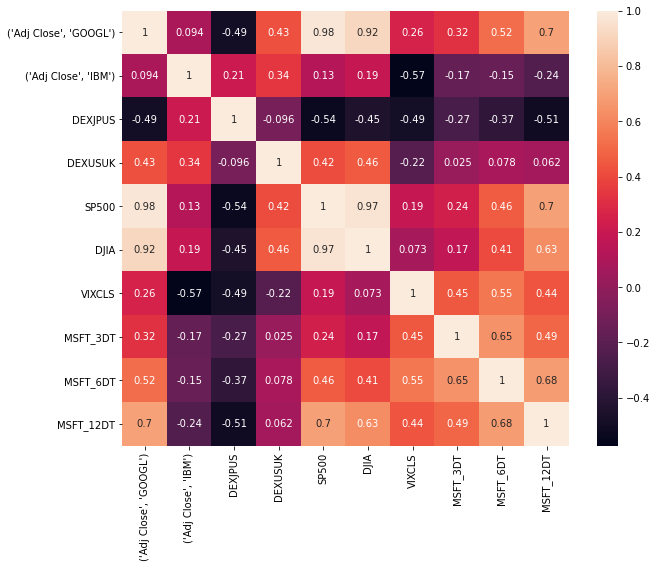

In [45]:
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(),annot=True )

In [46]:
#sns.pairplot(X, hue="SP500")

In [47]:
lower_cor = pd.DataFrame(np.tril(X.corr(), -1), columns = X.columns)
lower_cor

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.093681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,-0.494767,0.210694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.428291,0.340352,-0.096043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.976016,0.127624,-0.536218,0.415541,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,0.916880,0.190661,-0.445530,0.458584,0.966801,0.000000,0.000000,0.000000,0.000000,0.0
6,0.260507,-0.573092,-0.487589,-0.221913,0.194615,0.073058,0.000000,0.000000,0.000000,0.0
7,0.319392,-0.166611,-0.271338,0.024742,0.240561,0.174276,0.452226,0.000000,0.000000,0.0
8,0.519882,-0.151401,-0.372450,0.078487,0.463561,0.405242,0.552726,0.648137,0.000000,0.0
9,0.704874,-0.240512,-0.511481,0.062059,0.697977,0.625247,0.436171,0.494478,0.684979,0.0


> #### Drop features  correlation > |0.9|

In [48]:
to_drop = [column for column in lower_cor if any(lower_cor[column] > abs(0.9) )]
to_drop

[('Adj Close', 'GOOGL'), 'SP500']

In [49]:
X = X.drop(to_drop, axis=1)
X

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,1.937815,0.839018,-1.296609,-1.464163,-0.762129,-0.321600,-0.932762,-0.878558
1,1.970009,0.856758,-1.384129,-1.469902,-0.667495,-0.319597,-0.867497,-0.865812
2,2.133290,1.424427,-1.591515,-1.400836,-0.710822,-0.401712,-0.892405,-0.900223
3,2.024435,1.704714,-1.688548,-1.426471,-0.794054,-0.326940,-0.838827,-0.889165
4,1.987641,1.757933,-1.722795,-1.425847,-0.890968,-0.346969,-0.786013,-0.889839
...,...,...,...,...,...,...,...,...
1059,1.785111,-0.019582,1.945447,1.669759,-0.147578,2.341893,1.718159,0.634757
1060,1.769247,0.225225,1.797043,1.664444,-0.083729,2.450682,1.776969,0.318765
1061,1.943764,-0.079897,1.941642,1.705283,-0.268436,2.009131,1.386494,-0.026297
1062,1.999759,-0.140212,1.949252,1.676558,-0.268436,1.660016,1.411781,-0.167500


# Train / Test Preparation

In [50]:
test_size = int(0.3 * len(X))
train_size = int(0.7 * len(X))
X_train, X_test = X[0:int(train_size)], X[int(train_size):len(X)]
Y_train, Y_test = Y[0:int(train_size)], Y[int(train_size):len(X)]


In [51]:
print("X_Train :",X_train.shape)
print("X_Test : ",X_test.shape)
print("Y_Train :",Y_train.shape)
print("Y_Test : ",Y_test.shape)

X_Train : (744, 8)
X_Test :  (320, 8)
Y_Train : (744, 1)
Y_Test :  (320, 1)


# Model Training and Cross Validation

In [52]:
#Set number of fold / Seed value
Num_fold = 5
seed = 4

# Cross Validation Model
> ## set k-fold crossvalidation with shuffle

In [99]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=Num_fold, shuffle = True, random_state=seed)

# Model selection

In [100]:
model_LM = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
c_val = 6

In [101]:
svr_lin = SVR(kernel='linear', C=c_val)
svr_rbf = SVR(kernel='rbf', C=c_val, gamma=0.07)
svr_poly = SVR(kernel='poly', C=c_val, degree=2)

# Calculate accuracy score for each model

In [102]:
score_LM = cross_val_score(model_LM, X_train, Y_train, cv=kfold)
score_LM

array([0.92704989, 0.9494211 , 0.94042398, 0.94531547, 0.95627332])

In [103]:
score_lin = cross_val_score(svr_lin, X_train, Y_train, cv=kfold)
score_lin

C:\Users\ACER-OAT\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\ACER-OAT\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\ACER-OAT\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\ACER-OAT\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exa

array([0.90158761, 0.94835757, 0.93487196, 0.94943173, 0.94282993])

In [104]:
score_rbf = cross_val_score(svr_rbf, X_train, Y_train, cv=kfold)
score_rbf

C:\Users\ACER-OAT\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\ACER-OAT\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\ACER-OAT\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\ACER-OAT\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exa

array([0.86976452, 0.93714858, 0.91882313, 0.94083323, 0.92403074])

In [105]:
score_poly = cross_val_score(svr_poly, X_train, Y_train, cv=kfold)
score_poly

C:\Users\ACER-OAT\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\ACER-OAT\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\ACER-OAT\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\ACER-OAT\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exa

array([0.8363243 , 0.90775949, 0.86080248, 0.91065888, 0.90632332])

In [106]:
score = pd.DataFrame({'Linear Model':score_LM,'SVR_linear':score_lin, 'SVR_rbf': score_rbf, 'SVR_poly':score_poly})

In [107]:
score

,Linear Model,SVR_linear,SVR_rbf,SVR_poly
0,0.927050,0.901588,0.869765,0.836324
1,0.949421,0.948358,0.937149,0.907759
2,0.940424,0.934872,0.918823,0.860802
3,0.945315,0.949432,0.940833,0.910659
4,0.956273,0.942830,0.924031,0.906323


In [108]:
score_mean = pd.DataFrame({
    'AVG Linear Model':[score_LM.mean()],
   'AVG SVR_linear':[score_lin.mean()],
    'AVG SVR_rbf': [score_rbf.mean()], 
    'AVG SVC_poly': [score_poly.mean()]}
)
score_mean

,AVG Linear Model,AVG SVR_linear,AVG SVR_rbf,AVG SVC_poly
0,0.943697,0.935416,0.91812,0.884374


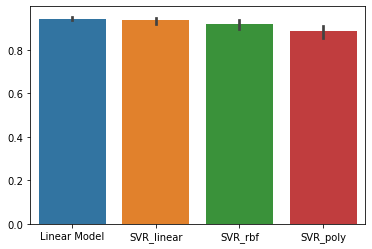

In [109]:
ax = sns.barplot(data=score)

# 5.3 Prediction and Evaluation

In [110]:
svr_lin 
svr_rbf 
svr_poly 

SVR(C=6, degree=2, kernel='poly')

In [111]:
LM_pred = model_LM.fit(X_train, Y_train).predict(X_test)
LM_pred.shape

(320, 1)

In [112]:
SVRLIN_pred = svr_lin.fit(X_train, Y_train).predict(X_test)
SVRLIN_pred.shape

C:\Users\ACER-OAT\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(320,)

In [113]:
SVRRBF_pred = svr_rbf.fit(X_train, Y_train).predict(X_test)
SVRRBF_pred.shape

C:\Users\ACER-OAT\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(320,)

In [114]:
SVRPOLY_pred = svr_poly.fit(X_train, Y_train).predict(X_test)
SVRPOLY_pred.shape

C:\Users\ACER-OAT\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(320,)